In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import generate_video_with_text, create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox

import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

## three recordings
1) 2024_0409_183417_103.MP4 - Dlow, 60hz, great position for central current! and side vortex > extents
2) 2024_0409_183630_104.MP4 - Dhigh, 60hz, >2min, many many particles and many captures, dorsal view, clean view, poops, moves
3) 2024_0409_183844_105.MP4 - similar to (2) but shorter

In [16]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0409_183630_104.MP4"  
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = vid_props
print(vid_props)

results_save_path = f"./data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(results_save_path, exist_ok=True)

pixel_per_real_width = .61
mpp = 1.65  # microns_per_pixel
print("D high - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = True
export_frames = np.arange(0, num_frames, 1)
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), frames_filepaths, export_frames) if EXPORT_FRAMES else None


(60, 7833, 1920, 1080)
D high - FHD, pixel_per_real_width =  0.61


In [17]:
img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0409_183630_104/*.jpg
    Length: 7833 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8

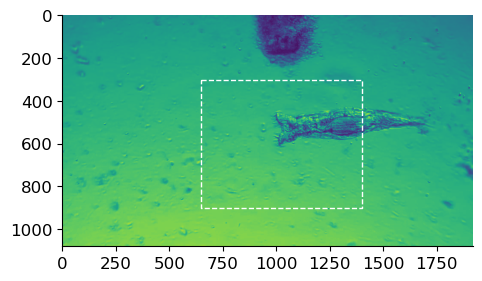

In [26]:
zoom_in = [650, 1400, 300, 900] 

plt.figure()
plt.imshow(frames[2500])
plot_bbox(zoom_in)

In [27]:
# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = True
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

In [28]:
capture_frames = [[0,44],[46,85],[140, 176],[271,306],[439,482],[549,575],[596,627],[735,764],[812,850],[955,993],[1014,1048],[1049,1080],[1214,1254],[1338,1375],[1600,1630],
                  [1693,1723],[1829,1858],[1859,1912],[2133,2191],[2244,2269],[2472,2520],[2534,2568],[2820,2864],[3040,3077],[3156,3187],[3362,3390],[3515,3545],
                  [3601,3671],[3718,3739],[3751,3788],[3899,3930],[4061,4090],[4209,4243],[4283,4306],[4565,4619],[4628,4662],
                  [4794,4845],[4851,4883],[5009,5050],[5597,5627],[5636,5687],[5704,5745],[5736,5818],[5879,5923],[6529,6578],[6724,6767],[6896,6935],[7695,7723]]
#[1159,1186]
#[2820,2864] while moving
# [1859,1912]**
len(capture_frames)

48

# 2024_0409_183844_105.MP4

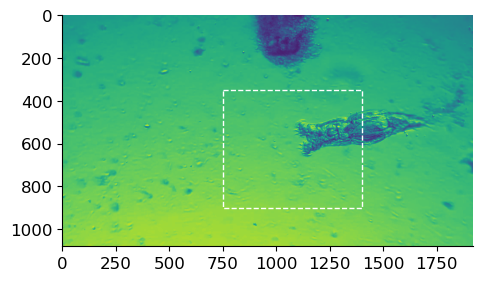

In [13]:
zoom_in = [750, 1400, 350, 900] 

plt.figure()
plt.imshow(frames[1900])
plot_bbox(zoom_in)

In [14]:
# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = True
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

In [ ]:
capture_frames = [[0,38],[60,95],[372,398],[426,466],[437,490],[542,579],[735,765],[919,975],
                  [975,1016],[1167,1191],[1305,1349],[1553,1611],[1737,1777],[1817,1899],
                  [1863,1913],[],[],[],[],[]]
# [1167,1191] same traj, one is taken, the other not!
# [1553,1611] smt weird
# [1737,1777]**
# [1817,1899], two captures, far away